# **Projet : Conversion rate challenge**

## Partie 0 : import des librairies et du data_train

In [1]:
# EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV

# Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

# Modèle de base
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Méthode d'ensemble
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
data_train = pd.read_csv('conversion_data_train.csv')
data_train.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


## Partie 1 : EDA et Preprocessing

In [3]:
print("Nombre de lignes :")
print(data_train.shape[0])
print()
print("Stats de base :")
display(data_train.describe(include="all"))
print()
print("Percentage of missing values :")
display(100*data_train.isnull().sum()/data_train.shape[0])
print()
print("Proportions des personnes abonnés l'ensemble des utilisateurs :", data_train["converted"].mean())
print("Proportions des personnes non abonnés l'ensemble des utilisateurs :", 1 - data_train["converted"].mean())

Nombre de lignes :
284580

Stats de base :


,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000



Percentage of missing values :


country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64


Proportions des personnes abonnés l'ensemble des utilisateurs : 0.03225806451612903
Proportions des personnes non abonnés l'ensemble des utilisateurs : 0.967741935483871


**Remarques :** \
Il ne manque aucune valeur. \
Il est indiqué qu'au moins une personne a 123 ans... Ceci sera à étudier !


### Variable country

In [4]:
data_train["country"].value_counts(dropna=False)

country
US         160124
China       69122
UK          43641
Germany     11693
Name: count, dtype: int64

On peut voir que les utilisateurs enregistrés dans la base de données sont originaires de seulement 4 pays :
- Etats-Unis
- Chine
- Royaume-Uni
- Allemagne

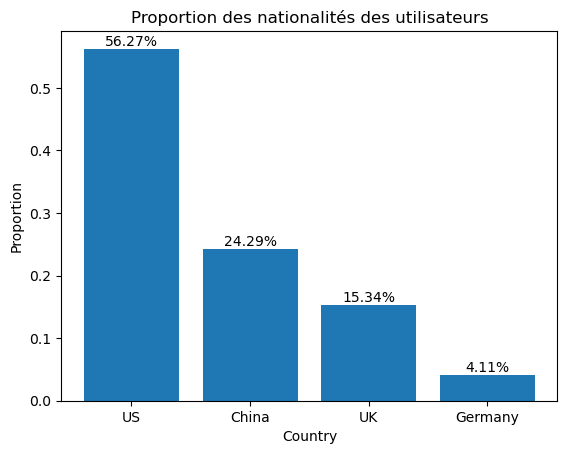

In [5]:
# On affiche les proportions des nationalités des utilisateurs du dataset
plt.figure()
plt.bar(data_train["country"].value_counts().index, data_train["country"].value_counts().values/data_train.shape[0])
plt.title("Proportion des nationalités des utilisateurs")
plt.xlabel("Country")
plt.ylabel("Proportion")

for i, count in enumerate(data_train["country"].value_counts()):
    plt.text(i, count/data_train.shape[0], str(round(100*count/data_train.shape[0] , 2)) + "%", ha='center', va = 'bottom')
plt.show()

**Remarque :** \
Plus de la moitié des utilisateurs sont américains. Environ 25 % de utilisateurs sont chinois. Environ 15 % des utilisateurs sont anglais. Enfin, moins de 5 % des utilisateurs sont allemands.

In [6]:
# On calcule le nombre de personnes de chaque nationalité qui sont abonnés
data_country_converted = data_train.groupby("country").sum()["converted"].sort_values(ascending=False)
data_country_converted

country
US         6070
UK         2291
Germany     730
China        89
Name: converted, dtype: int64

In [7]:
# Il sera plus interessant de visualiser les proportions
data_country_converted_prop = (data_country_converted/data_train["country"].value_counts()).sort_values(ascending=False)
data_country_converted_prop

country
Germany    0.062431
UK         0.052497
US         0.037908
China      0.001288
dtype: float64

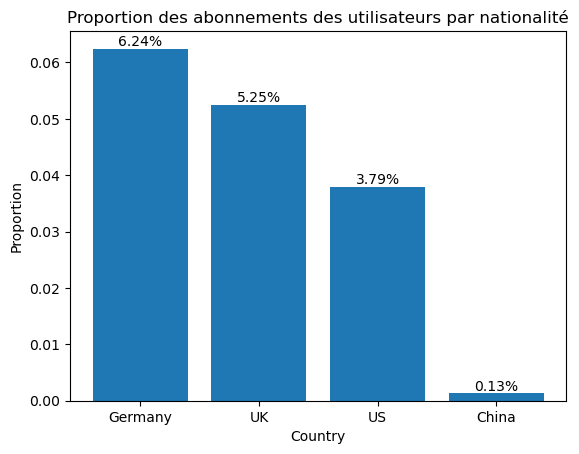

In [8]:
# On affiche les proportions des personnes qui se sont abonnés par nationalité

plt.figure()
plt.bar(data_country_converted_prop.index, data_country_converted_prop.values)
plt.title("Proportion des abonnements des utilisateurs par nationalité")
plt.xlabel("Country")
plt.ylabel("Proportion")

for i, count in enumerate(data_country_converted_prop):
    plt.text(i, count, str(round(100*count , 2)) + "%", ha='center', va = 'bottom')
plt.show()

**Remarques :** \
De manière générale, peu de personnes s'abonnent au site. \
Seulement 0.13 % des chinois s'abonnent au site.

### Variable age

In [9]:
data_train["age"].value_counts().sort_index()

age
17      6825
18      7662
19      8452
20      9131
21      9870
22     10471
23     11097
24     11647
25     12157
26     12525
27     12668
28     12972
29     12710
30     12956
31     12327
32     12111
33     11392
34     10911
35     10352
36      9668
37      8773
38      8067
39      7343
40      6451
41      5783
42      5029
43      4423
44      3808
45      3249
46      2693
47      2255
48      1898
49      1467
50      1213
51       990
52       835
53       571
54       459
55       352
56       251
57       211
58       147
59       115
60        86
61        63
62        50
63        29
64        26
65        14
66         9
67         5
68         2
69         1
70         2
72         1
73         1
77         1
79         1
111        1
123        1
Name: count, dtype: int64

Une personne du dataset a 111 ans et une autre 123 ans. Au vu de l'écart qu'il y a avec la troisième personne la plus agée du dataset (79 ans), nous allons enlever les deux lignes qui correspondent aux deux personnes centenaires.

In [10]:
data_train = data_train.loc[data_train["age"] < 100]
print("Nombre de lignes restantes :", data_train.shape[0])

Nombre de lignes restantes : 284578


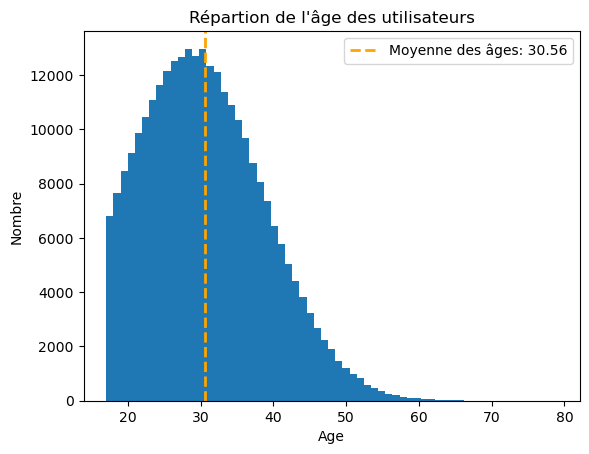

In [11]:
# Visualisons la répartion de l'âge des utilisateurs
plt.figure()
plt.hist(data_train["age"], bins=63) # On choisit 63 car l'âge va de 17 ans à 79 ans

plt.axvline(data_train["age"].mean(), c='orange', linestyle="dashed", linewidth=2, label=f'Moyenne des âges: {data_train["age"].mean():.2f}')

plt.title("Répartion de l'âge des utilisateurs")
plt.xlabel("Age")
plt.ylabel("Nombre")

plt.legend()
plt.show()

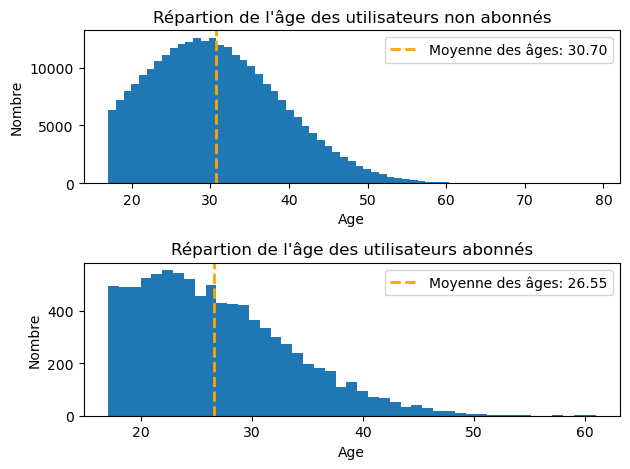

In [12]:
# Visualisons la répartition de l'âge des utilisateurs en fonction de s'il se sont abonnés ou non.
plt.figure()

plt.subplot(2,1,1)
# Visualisons la répartion de l'âge des utilisateurs non abonnés
plt.hist(data_train["age"].loc[data_train["converted"] == 0], bins=63) # On choisit 63 car l'âge va de 17 ans à 79 ans pour les personnes non abonnés
plt.axvline(data_train["age"].loc[data_train["converted"] == 0].mean(), c='orange', linestyle="dashed", linewidth=2, label=f'Moyenne des âges: {data_train["age"].loc[data_train["converted"] == 0].mean():.2f}')
plt.title("Répartion de l'âge des utilisateurs non abonnés")
plt.xlabel("Age")
plt.ylabel("Nombre")
plt.legend()

# Visualisons la répartion de l'âge des utilisateurs abonnés
plt.subplot(2,1,2)
plt.hist(data_train["age"].loc[data_train["converted"] == 1], bins=45) # On choisit 45 car l'âge va de 17 ans à 61 ans pour les personnes abonnés
plt.axvline(data_train["age"].loc[data_train["converted"] == 1].mean(), c='orange', linestyle="dashed", linewidth=2, label=f'Moyenne des âges: {data_train["age"].loc[data_train["converted"] == 1].mean():.2f}')
plt.title("Répartion de l'âge des utilisateurs abonnés")
plt.xlabel("Age")
plt.ylabel("Nombre")
plt.legend()

plt.tight_layout()
plt.show()

**Remarque :** \
Les utilisateurs abonnés représentent une population plus jeune que la population des utilisateurs non abonnés.

### Variable new_user

In [13]:
data_train["new_user"].value_counts()

new_user
1    195066
0     89512
Name: count, dtype: int64

Pour l'EDA de cette varible, on va remplacer chaque 0 par "Ancien utilisateur" et chaque 1 par "Nouvel utilisateur"

In [14]:
data_new_user = data_train.copy()
data_new_user["new_user"].loc[data_new_user["new_user"] == 0] = "Ancien utilisateur"
data_new_user["new_user"].loc[data_new_user["new_user"] == 1] = "Nouvel utilisateur"
data_new_user.head()

C:\Users\Théo REMY\AppData\Local\Temp\ipykernel_17276\3778567767.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_new_user["new_user"].loc[data_new_user["new_user"] == 0] = "Ancien utilisateur"
C:\Users\Théo REMY\AppData\Local\Temp\ipykernel_17276\3778567767.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Ancien utilisateur' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_new_user["new_user"].loc[data_new_user["new_user"] == 0] = "Ancien utilisateur"


,country,age,new_user,source,total_pages_visited,converted
0,China,22,Nouvel utilisateur,Direct,2,0
1,UK,21,Nouvel utilisateur,Ads,3,0
2,Germany,20,Ancien utilisateur,Seo,14,1
3,US,23,Nouvel utilisateur,Seo,3,0
4,US,28,Nouvel utilisateur,Direct,3,0


**Remarque :** \
Il n'est pas clairement défini ce qu'est un nouvel utilisateur...

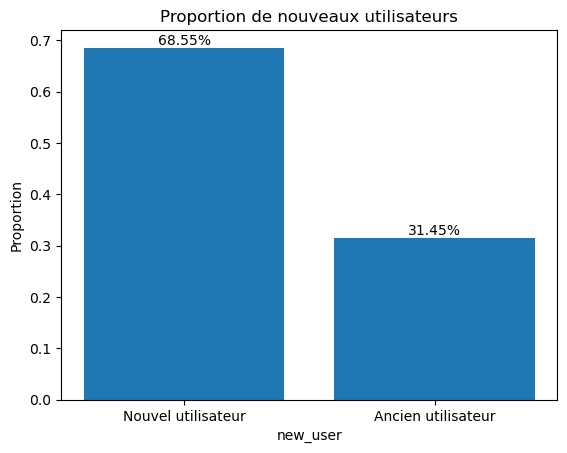

In [15]:
# On affiche les proportions des nationalités des utilisateurs du dataset
plt.figure()
plt.bar(data_new_user["new_user"].value_counts().index, data_new_user["new_user"].value_counts().values/data_new_user.shape[0])
plt.title("Proportion de nouveaux utilisateurs")
plt.xlabel("new_user")
plt.ylabel("Proportion")

for i, count in enumerate(data_new_user["new_user"].value_counts()):
    plt.text(i, count/data_new_user.shape[0], str(round(100*count/data_new_user.shape[0] , 2)) + "%", ha='center', va = 'bottom')
plt.show()

In [16]:
# On calcule le nombre de personnes de chaque classe de new_user qui sont abonnés
data_new_user_converted = data_new_user.groupby("new_user").sum()["converted"].sort_values(ascending=False)
data_new_user_converted

new_user
Ancien utilisateur    6437
Nouvel utilisateur    2741
Name: converted, dtype: int64

In [17]:
# Il sera plus interessant de visualiser les proportions
data_new_user_converted_prop = (data_new_user_converted/data_new_user["new_user"].value_counts()).sort_values(ascending=False)
data_new_user_converted_prop

new_user
Ancien utilisateur    0.071912
Nouvel utilisateur    0.014052
dtype: float64

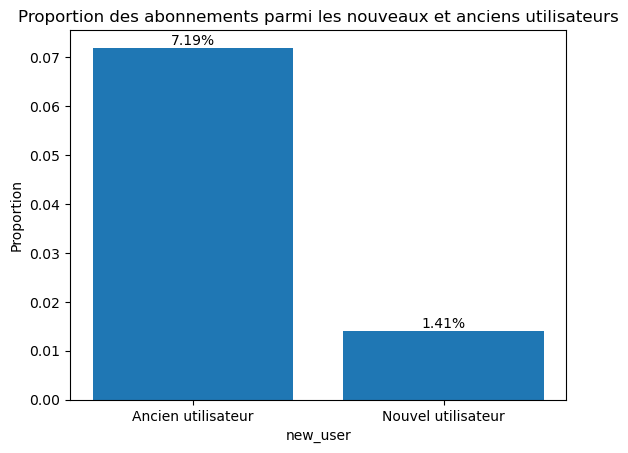

In [18]:
plt.figure()
plt.bar(data_new_user_converted_prop.index, data_new_user_converted_prop.values)
plt.title("Proportion des abonnements parmi les nouveaux et anciens utilisateurs")
plt.xlabel("new_user")
plt.ylabel("Proportion")

for i, count in enumerate(data_new_user_converted_prop):
    plt.text(i, count, str(round(100*count , 2)) + "%", ha='center', va = 'bottom')
plt.show()

**Remarque :** \
Il y a plus de nouveaux utilisateurs que d'anciens. \
Cependant, la proportion d'abonnés chez les anciens utilisateurs est plus grande que la proportion d'abonnés chez les nouveaux

### Variable source

In [19]:
data_train["source"].value_counts()

source
Seo       139476
Ads        80026
Direct     65076
Name: count, dtype: int64

On va rendre le nom des classes plus clair :
- Seo -> Via Recherche : l'utilisateur s'est connecté sur le site pour la première fois via une recherche sur internet
- Ads - Via Publicité : l'utilisateur s'est connecté sur le site pour la première fois via une publicité
- Direct -> Via URL : l'utilisateur s'est connecté sur le site pour la première fois via l'URL directement

In [20]:
data_source = data_train.copy()
data_source["source"].loc[data_source["source"] == "Seo"] = "Via Recherche"
data_source["source"].loc[data_source["source"] == "Ads"] = "Via Publicité"
data_source["source"].loc[data_source["source"] == "Direct"] = "Via URL"
data_source.head()

C:\Users\Théo REMY\AppData\Local\Temp\ipykernel_17276\1637838297.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_source["source"].loc[data_source["source"] == "Seo"] = "Via Recherche"
C:\Users\Théo REMY\AppData\Local\Temp\ipykernel_17276\1637838297.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_source["source"].loc[data_source["source"] == "Ads"] = "Via Publicité"
C:\Users\Théo REMY\AppData\Local\Temp\ipykernel_17276\1637838297.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Via URL,2,0
1,UK,21,1,Via Publicité,3,0
2,Germany,20,0,Via Recherche,14,1
3,US,23,1,Via Recherche,3,0
4,US,28,1,Via URL,3,0


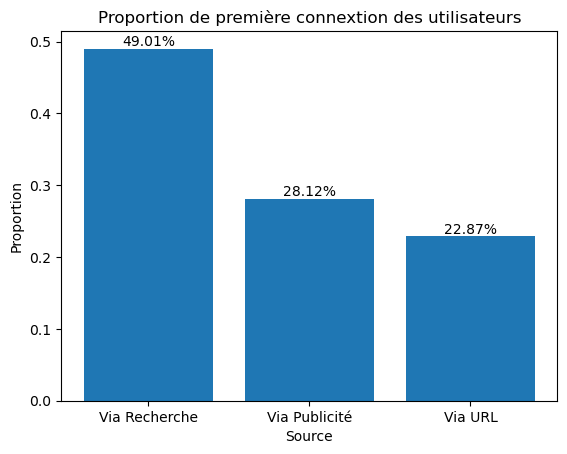

In [21]:
# On affiche les proportions des nationalités des utilisateurs du dataset
plt.figure()
plt.bar(data_source["source"].value_counts().index, data_source["source"].value_counts().values/data_source.shape[0])
plt.title("Proportion de première connextion des utilisateurs")
plt.xlabel("Source")
plt.ylabel("Proportion")

for i, count in enumerate(data_source["source"].value_counts()):
    plt.text(i, count/data_source.shape[0], str(round(100*count/data_source.shape[0] , 2)) + "%", ha='center', va = 'bottom')
plt.show()

**Remarque :** \
49 % des utilisateurs ont accédé au site la première fois via une recherche internet. \
28 % des utilisateurs ont accédé au site la première fois en cliquant sur un publicité. \
Enfin, 23 % des utilisateurs ont accédé au site la première fois en utilisant l'URL directement.

In [22]:
# On calcule le nombre de personnes de chaque classe de source qui sont abonnés
data_source_converted = data_source.groupby("source").sum()["converted"].sort_values(ascending=False)
data_source_converted_prop = (data_source_converted/data_source["source"].value_counts()).sort_values(ascending=False)
data_source_converted_prop

source
Via Publicité    0.034789
Via Recherche    0.032866
Via URL          0.027814
dtype: float64

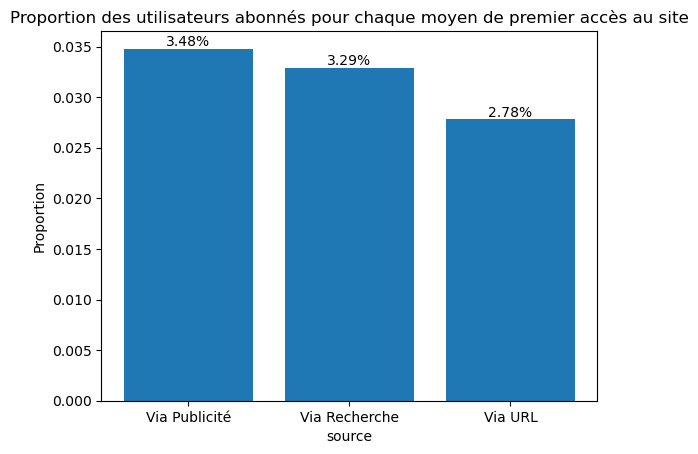

In [23]:
plt.figure()
plt.bar(data_source_converted_prop.index, data_source_converted_prop.values)
plt.title("Proportion des utilisateurs abonnés pour chaque moyen de premier accès au site")
plt.xlabel("source")
plt.ylabel("Proportion")

for i, count in enumerate(data_source_converted_prop):
    plt.text(i, count, str(round(100*count, 2)) + "%", ha='center', va = 'bottom')
plt.show()

**Remarque :** \
On ne remarque pas de différence évidente entre dans les proportions d'abonnés.

### Variable total_pages_visited

In [24]:
data_train["total_pages_visited"].value_counts().sort_index()

total_pages_visited
1     36637
2     39546
3     39465
4     36918
5     32654
6     27198
7     21112
8     15768
9     10972
10     7311
11     4846
12     3233
13     2191
14     1611
15     1195
16      997
17      767
18      653
19      506
20      372
21      266
22      162
23       99
24       40
25       34
26       15
27        7
28        1
29        2
Name: count, dtype: int64

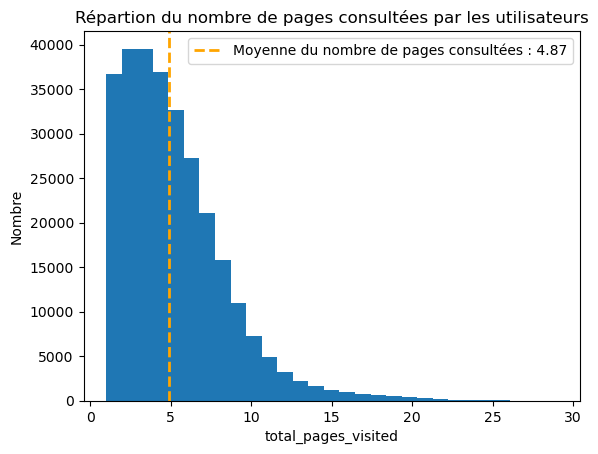

In [25]:
# Visualisons la répartion du nombre de pages consultées par les utilisateurs
plt.figure()
plt.hist(data_train["total_pages_visited"], bins=29) # On choisit 29 car le nombre va de 1 à 29

plt.axvline(data_train["total_pages_visited"].mean(), c='orange', linestyle="dashed", linewidth=2, label=f'Moyenne du nombre de pages consultées : {data_train["total_pages_visited"].mean():.2f}')

plt.title("Répartion du nombre de pages consultées par les utilisateurs")
plt.xlabel("total_pages_visited")
plt.ylabel("Nombre")

plt.legend()
plt.show()

In [26]:
data_train["total_pages_visited"].loc[data_train["converted"] == 1].value_counts().sort_index()

total_pages_visited
2       9
3      11
4      29
5      51
6      94
7     139
8     241
9     364
10    441
11    585
12    792
13    894
14    947
15    884
16    866
17    706
18    628
19    500
20    371
21    266
22    162
23     99
24     40
25     34
26     15
27      7
28      1
29      2
Name: count, dtype: int64

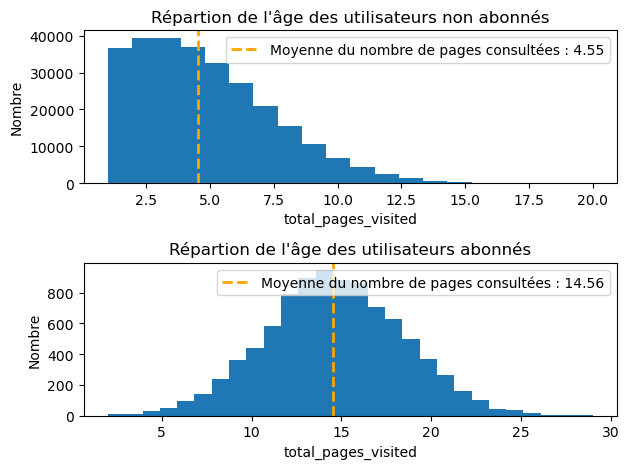

In [27]:
# Visualisons la répartion du nombre de pages consultées par les utilisateurs en fonction de s'il se sont abonnés ou non.
plt.figure()

plt.subplot(2,1,1)
# Visualisons la répartion du nombre de pages consultées par les utilisateurs non abonnés
plt.hist(data_train["total_pages_visited"].loc[data_train["converted"] == 0], bins=20) # On choisit 20 car le nombre va de 1 à 20 pour les personnes non abonnés
plt.axvline(data_train["total_pages_visited"].loc[data_train["converted"] == 0].mean(), c='orange', linestyle="dashed", linewidth=2, label=f'Moyenne du nombre de pages consultées : {data_train["total_pages_visited"].loc[data_train["converted"] == 0].mean():.2f}')
plt.title("Répartion de l'âge des utilisateurs non abonnés")
plt.xlabel("total_pages_visited")
plt.ylabel("Nombre")
plt.legend()

# Visualisons la répartion du nombre de pages consultées par les utilisateurs abonnés
plt.subplot(2,1,2)
plt.hist(data_train["total_pages_visited"].loc[data_train["converted"] == 1], bins=28) # On choisit 28 car le nombre va de 2 à 29 pour les personnes abonnés
plt.axvline(data_train["total_pages_visited"].loc[data_train["converted"] == 1].mean(), c='orange', linestyle="dashed", linewidth=2, label=f'Moyenne du nombre de pages consultées : {data_train["total_pages_visited"].loc[data_train["converted"] == 1].mean():.2f}')
plt.title("Répartion de l'âge des utilisateurs abonnés")
plt.xlabel("total_pages_visited")
plt.ylabel("Nombre")
plt.legend()

plt.tight_layout()
plt.show()

**Remarque :** \
Le nombre moyen de pages consultées par les utilisateurs abonnés est bien plus élevé que le nombre moyen de pages consultées par les utilisateurs non abonnés.

### Preprocessing

On crée les ensembles X (variables explicatives) et y (variable cible)

In [28]:
y = data_train["converted"]
X = data_train.drop("converted", axis=1)

print("y :")
print(y.head())
print()
print("X :")
print(X.head())

y :
0    0
1    0
2    1
3    0
4    0
Name: converted, dtype: int64

X :
   country  age  new_user  source  total_pages_visited
0    China   22         1  Direct                    2
1       UK   21         1     Ads                    3
2  Germany   20         0     Seo                   14
3       US   23         1     Seo                    3
4       US   28         1  Direct                    3


On crée deux listes : une liste avec les variables numériques et une liste avec les variables catégorielles.

In [29]:
numeric_features = []
categorical_features = []
for i,t in X.dtypes.items():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
    else :
        categorical_features.append(i)

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)

Found numeric features  ['age', 'new_user', 'total_pages_visited']
Found categorical features  ['country', 'source']


On divise X et y en train/val set.

In [30]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

On crée nos pipelines et notre preprocessor.

In [31]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OrdinalEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

On applique le preprocessor sur X_train et X_val.

In [32]:
print("Performing preprocessings on train set...")
print(X_train.head())
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5])
print()


print("Performing preprocessings on test set...")
print(X_val.head()) 
X_val = preprocessor.transform(X_val) 
print('...Done.')
print(X_val[0:5,:]) 
print()

Performing preprocessings on train set...
        country  age  new_user  source  total_pages_visited
14322        UK   37         1     Ads                    3
251570       UK   27         0     Seo                   13
53008        US   26         0  Direct                    4
121373       US   24         0     Seo                    1
151639  Germany   33         0     Ads                    2
...Done.
[[ 0.77869487  0.67629326 -0.56105227  2.          0.        ]
 [-0.43027253 -1.47864847  2.43067457  2.          2.        ]
 [-0.55116927 -1.47864847 -0.26187958  3.          1.        ]
 [-0.79296275 -1.47864847 -1.15939764  3.          2.        ]
 [ 0.29510791 -1.47864847 -0.86022495  1.          0.        ]]

Performing preprocessings on test set...
       country  age  new_user  source  total_pages_visited
144383   China   37         1  Direct                    2
38219    China   44         1     Ads                    3
227834      UK   24         0  Direct                 

Le nombre et la nature des colonnes est cohérente : 3 colonnes avec des float entre -1 et 1, et 5 colonnes (4 - 1 + 3 - 1) remplies de 0 et de 1.

## Partie 2 : Entrainement des modèles (à la recherche du meilleur modèle)

On va créer un dataframe qui va contenir tous les scores.

In [33]:
df_scores = pd.DataFrame(columns=["model", "f1_score", "set"])
df_scores

,model,f1_score,set


### Premier modèle : Random Forest

In [34]:
print("Grid search...")
rfc = RandomForestClassifier()
params = {
    'max_depth': [8,9,10],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [4, 5, 6],
    'n_estimators': [35, 40, 45]
}

gridsearch_rfc = GridSearchCV(rfc, scoring='f1', param_grid = params, cv = 3, n_jobs=-1)
gridsearch_rfc.fit(X_train, y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch_rfc.best_params_)
print("Best validation f1_score : ", gridsearch_rfc.best_score_)
print()
print("f1_score on training set :", gridsearch_rfc.score(X_train, y_train))
print("f1_score on val set :", gridsearch_rfc.score(X_val, y_val))

Grid search...


...Done.
Best hyperparameters :  {'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 45}
Best validation f1_score :  0.7637622726004741

f1_score on training set : 0.7685491138480025
f1_score on val set : 0.7556231003039514


On affiche les matrices de confusion.

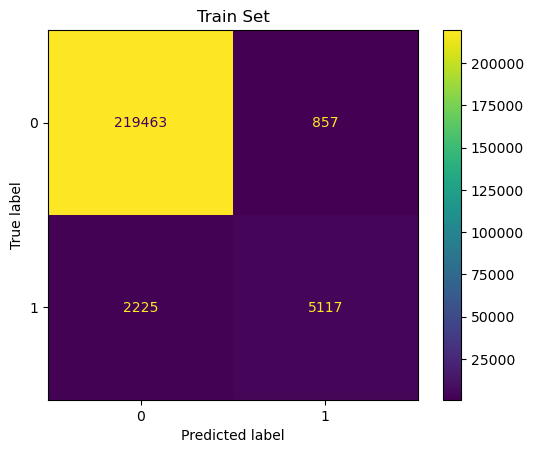

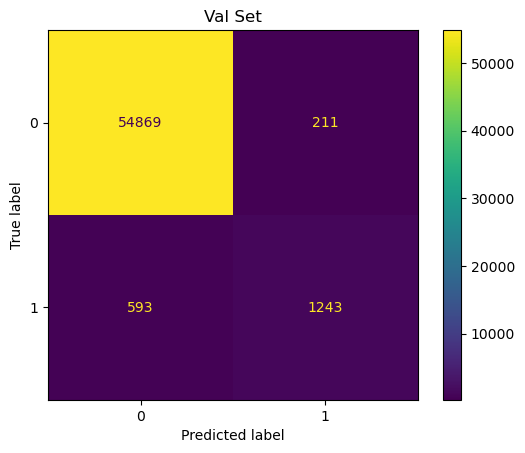

In [35]:
ConfusionMatrixDisplay.from_estimator(gridsearch_rfc.best_estimator_, X_train, y_train)
plt.title("Train Set")

ConfusionMatrixDisplay.from_estimator(gridsearch_rfc.best_estimator_, X_val, y_val)
plt.title("Val Set")
plt.show()

In [36]:
df_scores.loc[len(df_scores)] = pd.Series({df_scores.columns[0] : "random_forest", 
                                           df_scores.columns[1] : gridsearch_rfc.score(X_train, y_train),
                                           df_scores.columns[2] : "train"
                                           })

df_scores.loc[len(df_scores)] = pd.Series({df_scores.columns[0] : "random_forest", 
                                           df_scores.columns[1] : gridsearch_rfc.score(X_val, y_val),
                                           df_scores.columns[2] : "val"
                                           })

df_scores.head()

,model,f1_score,set
0,random_forest,0.768549,train
1,random_forest,0.755623,val


### Deuxième modèle : Bagging de regression logistique

In [37]:
logreg = LogisticRegression()

params = {
    'C': [0.1, 1.0, 10.0],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'lbfgs', 'saga'],
    'max_iter': [10, 25, 40],
}

gridsearch_logreg = GridSearchCV(logreg, scoring='f1', param_grid = params, cv = 3, n_jobs=-1)
gridsearch_logreg.fit(X_train, y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch_logreg.best_params_)
print("Best validation f1_score : ", gridsearch_logreg.best_score_)
print()
print("f1_score on training set :", gridsearch_logreg.score(X_train, y_train))
print("f1_score on val set :", gridsearch_logreg.score(X_val, y_val))

d:\Programmes\Anaconda\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
27 fits failed out of a total of 162.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Programmes\Anaconda\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Programmes\Anaconda\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Programmes\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1168, in fit
    solver = _check_s

...Done.
Best hyperparameters :  {'C': 1.0, 'max_iter': 25, 'penalty': 'l1', 'solver': 'saga'}
Best validation f1_score :  0.7505220150903286

f1_score on training set : 0.7507785795670339
f1_score on val set : 0.7484662576687118


In [38]:
print("Bagging of log reg...")
logreg = LogisticRegression(C=gridsearch_logreg.best_params_["C"], solver=gridsearch_logreg.best_params_["solver"], max_iter=gridsearch_logreg.best_params_["max_iter"])
bagging_log = BaggingClassifier(estimator=logreg, random_state=42)

params = {
    'n_estimators': [5, 10, 15],
    'max_samples': [0.7, 0.8, 0.9],
    'max_features': [0.8, 0.9, 1.0]
}

gridsearch_bagging_log = GridSearchCV(bagging_log, scoring='f1', param_grid = params, cv = 3, n_jobs=-1)
gridsearch_bagging_log.fit(X_train, y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch_bagging_log.best_params_)
print("Best validation f1_score : ", gridsearch_bagging_log.best_score_)
print()
print("f1_score on training set :", gridsearch_bagging_log.score(X_train, y_train))
print("f1_score on val set :", gridsearch_bagging_log.score(X_val, y_val))

Bagging of log reg...


...Done.
Best hyperparameters :  {'max_features': 1.0, 'max_samples': 0.9, 'n_estimators': 5}
Best validation f1_score :  0.7510646791569672

f1_score on training set : 0.7504187604690118
f1_score on val set : 0.7483870967741935


On affiche les matrices de confusion

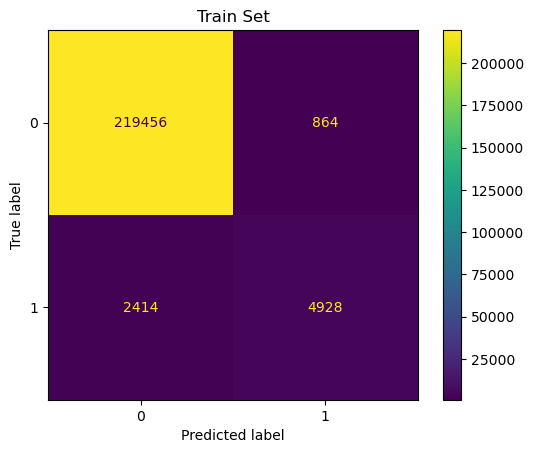

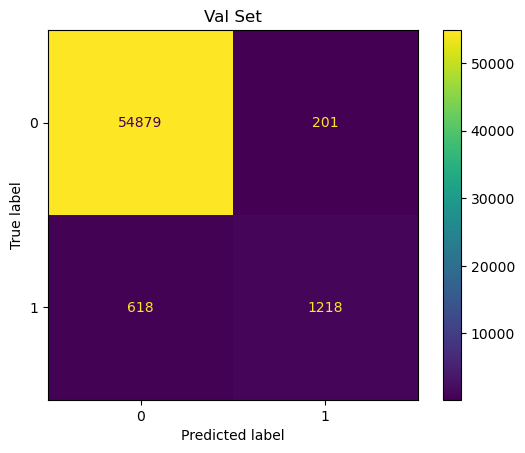

In [39]:
ConfusionMatrixDisplay.from_estimator(gridsearch_bagging_log.best_estimator_, X_train, y_train)
plt.title("Train Set")

ConfusionMatrixDisplay.from_estimator(gridsearch_bagging_log.best_estimator_, X_val, y_val)
plt.title("Val Set")
plt.show()

In [40]:
df_scores.loc[len(df_scores)] = pd.Series({df_scores.columns[0] : "Bagging_Log_Reg", 
                                           df_scores.columns[1] : gridsearch_bagging_log.score(X_train, y_train),
                                           df_scores.columns[2] : "train"
                                           })

df_scores.loc[len(df_scores)] = pd.Series({df_scores.columns[0] : "Bagging_Log_Reg", 
                                           df_scores.columns[1] : gridsearch_bagging_log.score(X_val, y_val),
                                           df_scores.columns[2] : "val"
                                           })

df_scores.head()

,model,f1_score,set
0,random_forest,0.768549,train
1,random_forest,0.755623,val
2,Bagging_Log_Reg,0.750419,train
3,Bagging_Log_Reg,0.748387,val


### Troisième modèle : SVC

In [41]:
svc = SVC(kernel='linear')

params = {
    'gamma': [0.01, 0.1, 1.0, 10.0],
    'C' : [0.01, 0.1, 1.0, 10.0]
}

gridsearch_svc = GridSearchCV(svc, scoring='f1', param_grid = params, cv = 3, n_jobs=-1)
gridsearch_svc.fit(X_train, y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch_svc.best_params_)
print("Best validation f1_score : ", gridsearch_svc.best_score_)
print()
print("f1_score on training set :", gridsearch_svc.score(X_train, y_train))
print("f1_score on val set :", gridsearch_svc.score(X_val, y_val))

...Done.
Best hyperparameters :  {'C': 1.0, 'gamma': 0.01}
Best validation f1_score :  0.7464455161584557

f1_score on training set : 0.7467592592592592
f1_score on val set : 0.7443305374339858


On affiche les matrices de confusion

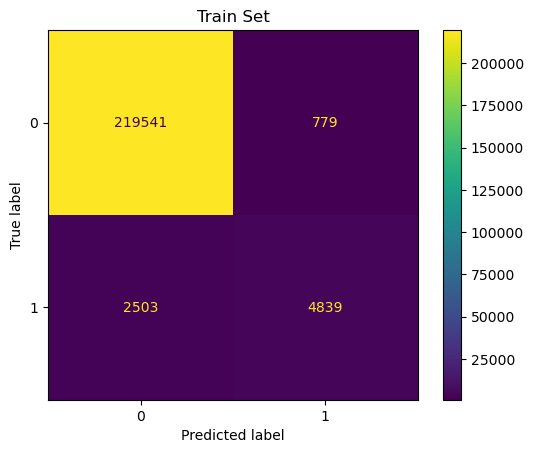

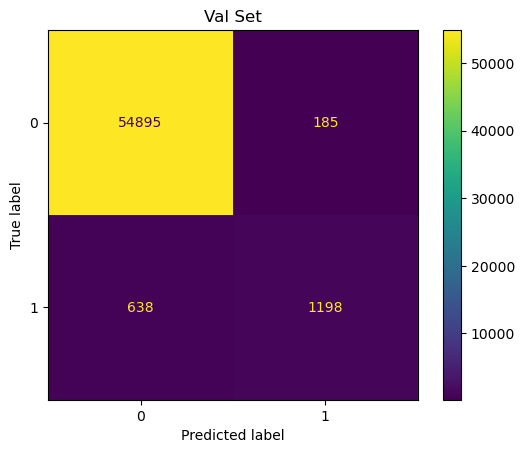

In [42]:
ConfusionMatrixDisplay.from_estimator(gridsearch_svc.best_estimator_, X_train, y_train)
plt.title("Train Set")

ConfusionMatrixDisplay.from_estimator(gridsearch_svc.best_estimator_, X_val, y_val)
plt.title("Val Set")
plt.show()

In [43]:
df_scores.loc[len(df_scores)] = pd.Series({df_scores.columns[0] : "Bagging_SVC", 
                                           df_scores.columns[1] : gridsearch_svc.score(X_train, y_train),
                                           df_scores.columns[2] : "train"
                                           })

df_scores.loc[len(df_scores)] = pd.Series({df_scores.columns[0] : "Bagging_SVC", 
                                           df_scores.columns[1] : gridsearch_svc.score(X_val, y_val),
                                           df_scores.columns[2] : "val"
                                           })

df_scores

,model,f1_score,set
0,random_forest,0.768549,train
1,random_forest,0.755623,val
2,Bagging_Log_Reg,0.750419,train
3,Bagging_Log_Reg,0.748387,val
4,Bagging_SVC,0.746759,train
5,Bagging_SVC,0.744331,val


### Quatrième méthode : Adaboost Decision Tree

In [44]:
print("Grid search...")
decision_tree = DecisionTreeClassifier()
ABC_dt = AdaBoostClassifier(decision_tree)


params = {
    'estimator__max_depth': [4, 6, 8],
    'estimator__min_samples_leaf': [1, 2, 3],
    'estimator__min_samples_split': [2, 4, 6],
    'n_estimators': [5,10,15]
}
print(params)
gridsearch_abc_dt = GridSearchCV(ABC_dt, scoring="f1", param_grid = params, cv = 3, n_jobs=-1)
gridsearch_abc_dt.fit(X_train, y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch_abc_dt.best_params_)
print("Best validation f1_score : ", gridsearch_abc_dt.best_score_)
print()
print("f1_score on training set : ", gridsearch_abc_dt.score(X_train, y_train))
print("f1_score on val set : ", gridsearch_abc_dt.score(X_val, y_val))

Grid search...
{'estimator__max_depth': [4, 6, 8], 'estimator__min_samples_leaf': [1, 2, 3], 'estimator__min_samples_split': [2, 4, 6], 'n_estimators': [5, 10, 15]}
...Done.
Best hyperparameters :  {'estimator__max_depth': 4, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'n_estimators': 10}
Best validation f1_score :  0.7622877342825015

f1_score on training set :  0.761539618102541
f1_score on val set :  0.76103500761035


On affiche les matrices de confusion

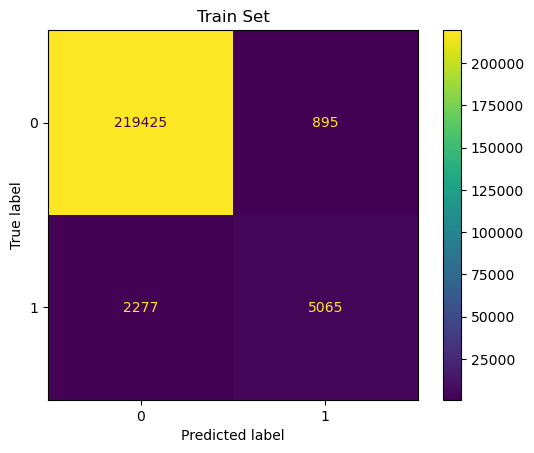

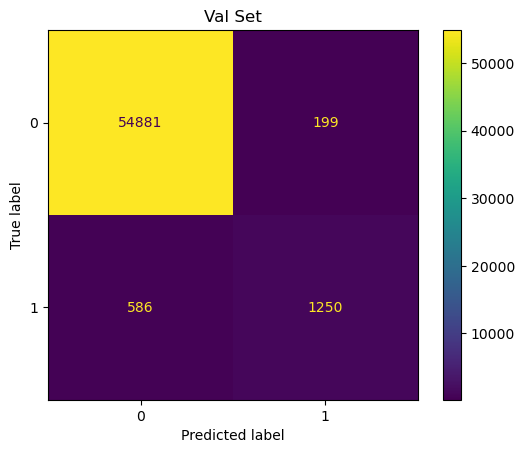

In [45]:
ConfusionMatrixDisplay.from_estimator(gridsearch_abc_dt.best_estimator_, X_train, y_train)
plt.title("Train Set")

ConfusionMatrixDisplay.from_estimator(gridsearch_abc_dt.best_estimator_, X_val, y_val)
plt.title("Val Set")
plt.show()

In [46]:
df_scores.loc[len(df_scores)] = pd.Series({df_scores.columns[0] : "adaboost_dt", 
                                           df_scores.columns[1] : gridsearch_abc_dt.score(X_train, y_train),
                                           df_scores.columns[2] : "train"
                                           })

df_scores.loc[len(df_scores)] = pd.Series({df_scores.columns[0] : "adaboost_dt", 
                                           df_scores.columns[1] : gridsearch_abc_dt.score(X_val, y_val),
                                           df_scores.columns[2] : "val"
                                           })
df_scores

,model,f1_score,set
0,random_forest,0.768549,train
1,random_forest,0.755623,val
2,Bagging_Log_Reg,0.750419,train
3,Bagging_Log_Reg,0.748387,val
4,Bagging_SVC,0.746759,train
5,Bagging_SVC,0.744331,val
6,adaboost_dt,0.76154,train
7,adaboost_dt,0.761035,val


### Cinquième modèle : Adaboost Regression Logistique

In [47]:
print("Grid search...")
log_reg = LogisticRegression()
ABC_lg = AdaBoostClassifier(log_reg)

params = {
    'estimator__C': [1.0, 10.0, 100.0],
    'estimator__penalty': ['l1', 'l2'],
    'estimator__solver': ['liblinear', 'lbfgs', 'saga'],
    'estimator__max_iter': [10, 25, 40],
    'n_estimators': [10,15,20]
}

print(params)
gridsearch_abc_lg = GridSearchCV(ABC_lg, scoring="f1", param_grid = params, cv = 3, n_jobs=-1)
gridsearch_abc_lg.fit(X_train, y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch_abc_lg.best_params_)
print("Best validation f1_score : ", gridsearch_abc_lg.best_score_)
print()
print("f1_score on training set : ", gridsearch_abc_lg.score(X_train, y_train))
print("f1_score on val set : ", gridsearch_abc_lg.score(X_val, y_val))

Grid search...
{'estimator__C': [1.0, 10.0, 100.0], 'estimator__penalty': ['l1', 'l2'], 'estimator__solver': ['liblinear', 'lbfgs', 'saga'], 'estimator__max_iter': [10, 25, 40], 'n_estimators': [10, 15, 20]}


d:\Programmes\Anaconda\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
81 fits failed out of a total of 486.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
81 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Programmes\Anaconda\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Programmes\Anaconda\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Programmes\Anaconda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py", line 171, in fit
    sample_weight, 

...Done.
Best hyperparameters :  {'estimator__C': 10.0, 'estimator__max_iter': 10, 'estimator__penalty': 'l2', 'estimator__solver': 'lbfgs', 'n_estimators': 10}
Best validation f1_score :  0.7509555005061953

f1_score on training set :  0.7518159806295399
f1_score on val set :  0.7532070861331704


On affiche les matrices de confusion

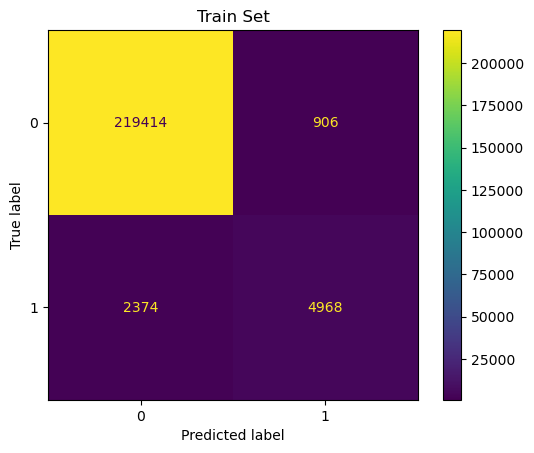

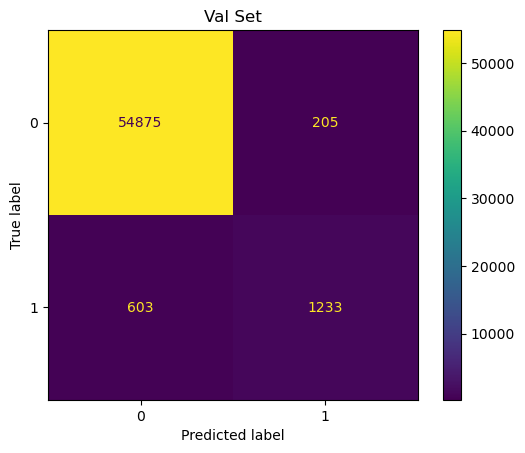

In [48]:
ConfusionMatrixDisplay.from_estimator(gridsearch_abc_lg.best_estimator_, X_train, y_train)
plt.title("Train Set")

ConfusionMatrixDisplay.from_estimator(gridsearch_abc_lg.best_estimator_, X_val, y_val)
plt.title("Val Set")
plt.show()

In [49]:
df_scores.loc[len(df_scores)] = pd.Series({df_scores.columns[0] : "adaboost_lg", 
                                           df_scores.columns[1] : gridsearch_abc_lg.score(X_train, y_train),
                                           df_scores.columns[2] : "train"
                                           })

df_scores.loc[len(df_scores)] = pd.Series({df_scores.columns[0] : "adaboost_lg", 
                                           df_scores.columns[1] : gridsearch_abc_lg.score(X_val, y_val),
                                           df_scores.columns[2] : "val"
                                           })
df_scores

,model,f1_score,set
0,random_forest,0.768549,train
1,random_forest,0.755623,val
2,Bagging_Log_Reg,0.750419,train
3,Bagging_Log_Reg,0.748387,val
4,Bagging_SVC,0.746759,train
5,Bagging_SVC,0.744331,val
6,adaboost_dt,0.76154,train
7,adaboost_dt,0.761035,val
8,adaboost_lg,0.751816,train
9,adaboost_lg,0.753207,val


### Sixième modèle : Gradient Boosting Classifier

In [50]:
# Perform grid search
print("Grid search...")
gbc = GradientBoostingClassifier()

# Grid of values to be tested
params = {
    'max_depth': [6, 8, 10], 
    'min_samples_leaf': [2, 3, 4],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [10, 15, 20]
}
print(params)
gridsearch_gbc = GridSearchCV(gbc, scoring="f1", param_grid = params, cv = 5)
gridsearch_gbc.fit(X_train, y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch_gbc.best_params_)
print("Best validation f1_score : ", gridsearch_gbc.best_score_)
print()
print("f1_score on training set : ", gridsearch_gbc.score(X_train, y_train))
print("f1_score on test set : ", gridsearch_gbc.score(X_val, y_val))

Grid search...
{'max_depth': [6, 8, 10], 'min_samples_leaf': [2, 3, 4], 'min_samples_split': [8, 10, 12], 'n_estimators': [10, 15, 20]}
...Done.
Best hyperparameters :  {'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 12, 'n_estimators': 20}
Best validation f1_score :  0.758243509577804

f1_score on training set :  0.7621448212648946
f1_score on test set :  0.7555418719211823


On affiche les matrices de confusion

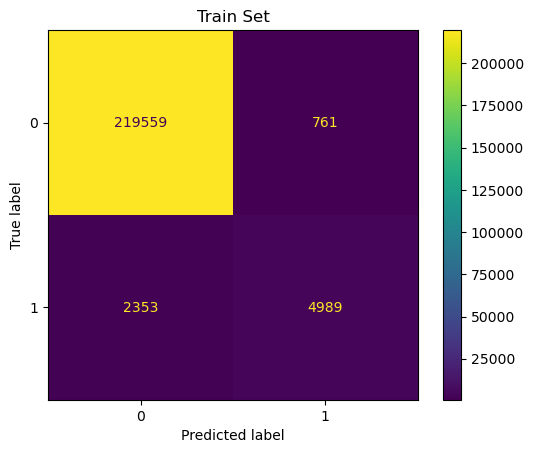

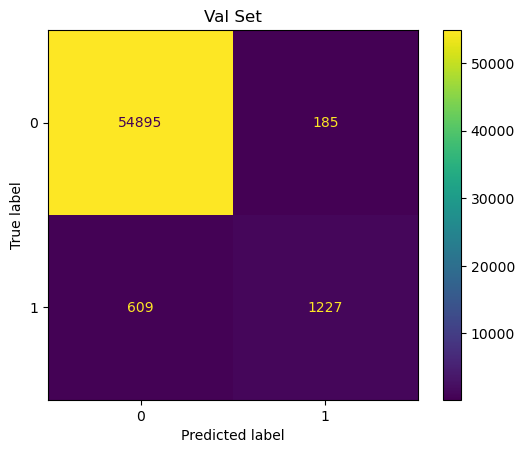

In [51]:
ConfusionMatrixDisplay.from_estimator(gridsearch_gbc.best_estimator_, X_train, y_train)
plt.title("Train Set")

ConfusionMatrixDisplay.from_estimator(gridsearch_gbc.best_estimator_, X_val, y_val)
plt.title("Val Set")
plt.show()

In [52]:
df_scores.loc[len(df_scores)] = pd.Series({df_scores.columns[0] : "GradientBoostClassifier", 
                                           df_scores.columns[1] : gridsearch_gbc.score(X_train, y_train),
                                           df_scores.columns[2] : "train"
                                           })

df_scores.loc[len(df_scores)] = pd.Series({df_scores.columns[0] : "GradientBoostClassifier", 
                                           df_scores.columns[1] : gridsearch_gbc.score(X_val, y_val),
                                           df_scores.columns[2] : "val"
                                           })
df_scores

,model,f1_score,set
0,random_forest,0.768549,train
1,random_forest,0.755623,val
2,Bagging_Log_Reg,0.750419,train
3,Bagging_Log_Reg,0.748387,val
4,Bagging_SVC,0.746759,train
5,Bagging_SVC,0.744331,val
6,adaboost_dt,0.76154,train
7,adaboost_dt,0.761035,val
8,adaboost_lg,0.751816,train
9,adaboost_lg,0.753207,val


### Septième modèle : XGBoost

In [53]:
# Perform grid search
print("Grid search...")
xgboost = XGBClassifier()

# Grid of values to be tested
params = {
    'max_depth': [4, 6, 8, 10], # exactly the same role as in scikit-learn
    'min_child_weight': [1, 2, 4, 6, 8, 10], # effect is more or less similar to min_samples_leaf and min_samples_split
    'n_estimators': [50,100,150] # exactly the same role as in scikit-learn
}
print(params)
gridsearch_xgboost = GridSearchCV(xgboost, scoring="f1", param_grid = params, cv = 10, n_jobs=-1) # cv : the number of folds to be used for CV
gridsearch_xgboost.fit(X_train, y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch_xgboost.best_params_)
print("Best validation f1_score : ", gridsearch_xgboost.best_score_)
print()
print("f1_score on training set : ", gridsearch_xgboost.score(X_train, y_train))
print("f1_score on test set : ", gridsearch_xgboost.score(X_val, y_val))

Grid search...
{'max_depth': [4, 6, 8, 10], 'min_child_weight': [1, 2, 4, 6, 8, 10], 'n_estimators': [50, 100, 150]}
...Done.
Best hyperparameters :  {'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 50}
Best validation f1_score :  0.7644738071752245

f1_score on training set :  0.7673371359951967
f1_score on test set :  0.7570862541907956


On affiche la matrice de confusion

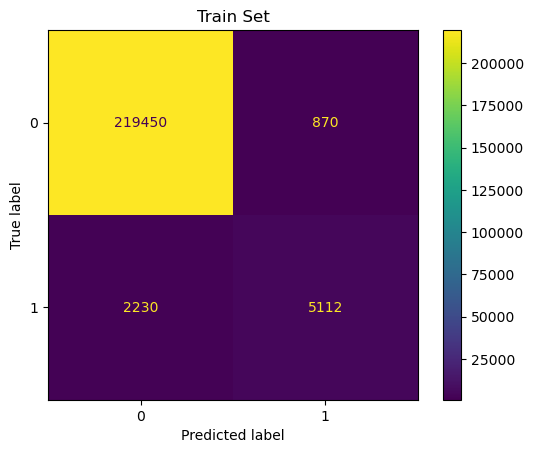

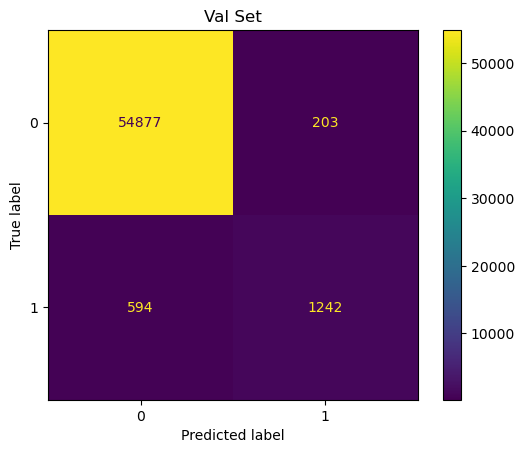

In [54]:
ConfusionMatrixDisplay.from_estimator(gridsearch_xgboost.best_estimator_, X_train, y_train)
plt.title("Train Set")

ConfusionMatrixDisplay.from_estimator(gridsearch_xgboost.best_estimator_, X_val, y_val)
plt.title("Val Set")
plt.show()

In [55]:
df_scores.loc[len(df_scores)] = pd.Series({df_scores.columns[0] : "xgboost", 
                                           df_scores.columns[1] : gridsearch_xgboost.score(X_train, y_train),
                                           df_scores.columns[2] : "train"
                                           })

df_scores.loc[len(df_scores)] = pd.Series({df_scores.columns[0] : "xgboost", 
                                           df_scores.columns[1] : gridsearch_xgboost.score(X_val, y_val),
                                           df_scores.columns[2] : "val"
                                           })
df_scores

,model,f1_score,set
0,random_forest,0.768549,train
1,random_forest,0.755623,val
2,Bagging_Log_Reg,0.750419,train
3,Bagging_Log_Reg,0.748387,val
4,Bagging_SVC,0.746759,train
5,Bagging_SVC,0.744331,val
6,adaboost_dt,0.76154,train
7,adaboost_dt,0.761035,val
8,adaboost_lg,0.751816,train
9,adaboost_lg,0.753207,val


### Visualisation des scores, choix du modèle

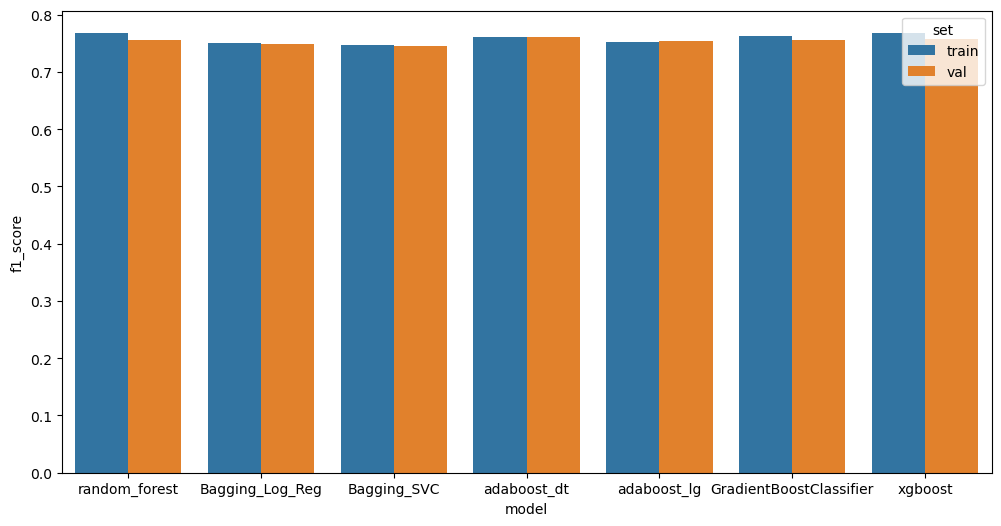

In [56]:
plt.figure(figsize=(12,6))
sns.barplot(df_scores, x='model', y="f1_score", hue="set")
plt.show()

Chaque modèle a des scores très similaires. \
**Par la suite, nous allons garder le XGBoost, pour deux raisons :** \
**- il possède des scores équivalents aux autres** \
**- c'est le modèle qui est le plus rapide à s'executer (et de loin)**

## Partie 3 : Amélioration du modèle choisi (XGBoost)

Pour améliorer notre XGBoost, on va utiliser :
- la méthode RandomizedSearchCV
- une régularisation (Ridge / Lasso)
- sélection de colonnes

### Modèle de base

In [57]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

print("Grid search...")
xgboost = XGBClassifier()

param_dis = {
    'max_depth': randint(2,6), 
    'min_child_weight': randint(2,18), 
    'n_estimators': randint(57,68),
    "reg_lambda" : uniform(1.7,0.8), # Régularisation Ridge [loc, loc+scale]
    "reg_alpha" : uniform(0.8,0.8) # Régularisation Lasso [loc, loc+scale]
}

random_xgboost = RandomizedSearchCV(xgboost, n_iter=100, scoring="f1", param_distributions = param_dis, cv = 10) # cv : the number of folds to be used for CV
random_xgboost.fit(X_train, y_train)
print("...Done.")
print("Best hyperparameters : ", random_xgboost.best_params_)
print("Best validation f1_score : ", random_xgboost.best_score_)
print()
print("f1_score on training set : ", random_xgboost.score(X_train, y_train))
print("f1_score on test set : ", random_xgboost.score(X_val, y_val))

Grid search...
...Done.
Best hyperparameters :  {'max_depth': 4, 'min_child_weight': 16, 'n_estimators': 61, 'reg_alpha': 1.0667855214632733, 'reg_lambda': 2.337333772667515}
Best validation f1_score :  0.7660313248077426

f1_score on training set :  0.7673824898633428
f1_score on test set :  0.7572166514737161


Affichons les coefficients associés à chaque paramètre dans un diagramme en barre.

In [58]:
best_xgboost = random_xgboost.best_estimator_
feature_importance = best_xgboost.feature_importances_

pd.DataFrame(feature_importance)

,0
0,0.023743
1,0.120588
2,0.750373
3,0.101243
4,0.004052


On va attribuer des noms aux index pour que ce soit plus clair.

In [59]:

coefs = pd.DataFrame(index = ["age", "new_user", "total_pages_visites", "country", "source"], data=feature_importance, columns=["coefs"]).sort_values(by="coefs", ascending=False)

<Axes: xlabel='coefs', ylabel='None'>

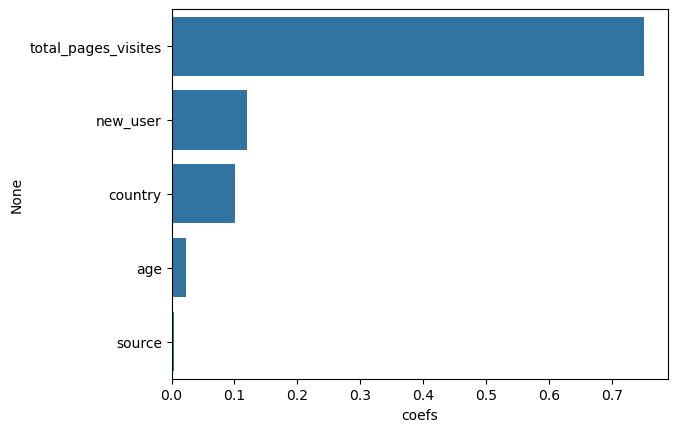

In [60]:
sns.barplot(abs(coefs), x="coefs", y=coefs.index, orient="h")

### Selection des colonnes

On remarque que les coefficients des colonnes "source" et "age" sont très faibles. Essayons d'enlever ces colonnes et lançons un XGBoost.

In [61]:
# Les colonnes "age" et "source" sont les dernières
X_train_cut = X_train[:, 1:4]
X_val_cut = X_val[:, 1:4]
X_train_cut

array([[ 0.67629326, -0.56105227,  2.        ],
       [-1.47864847,  2.43067457,  2.        ],
       [-1.47864847, -0.26187958,  3.        ],
       ...,
       [ 0.67629326, -0.86022495,  0.        ],
       [ 0.67629326,  0.33646578,  0.        ],
       [-1.47864847,  0.93481115,  0.        ]])

In [62]:
print("Grid search...")
xgboost = XGBClassifier()

param_dis = {
    'max_depth': randint(1,6), 
    'min_child_weight': randint(1,21), 
    'n_estimators': randint(50,71),
    "reg_lambda" : uniform(1.2,1.8), # Régularisation Ridge [loc, loc+scale]
    "reg_alpha" : uniform(0.8,1.2) # Régularisation Lasso [loc, loc+scale]
}

random_xgboost = RandomizedSearchCV(xgboost, n_iter=100, scoring="f1", param_distributions = param_dis, cv = 10) # cv : the number of folds to be used for CV
random_xgboost.fit(X_train_cut, y_train)
print("...Done.")
print("Best hyperparameters : ", random_xgboost.best_params_)
print("Best validation f1_score : ", random_xgboost.best_score_)
print()
print("f1_score on training set : ", random_xgboost.score(X_train_cut, y_train))
print("f1_score on test set : ", random_xgboost.score(X_val_cut, y_val))

Grid search...


...Done.
Best hyperparameters :  {'max_depth': 2, 'min_child_weight': 11, 'n_estimators': 52, 'reg_alpha': 1.6024780065295283, 'reg_lambda': 1.3897832216905095}
Best validation f1_score :  0.7495045247192141

f1_score on training set :  0.7565147177567348
f1_score on test set :  0.7554507955215085


On obtient de moins bons scores, on oublie cette idée.

### Oversampling / Undersampling

Comme nos classes sont très déséquilibrées, on va tester les méthodes d'oversampling et d'undersampling.

In [63]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

In [64]:
print("Grid search...")
xgboost = XGBClassifier()

# Oversampling
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

param_dis = {
    'max_depth': randint(2,6), 
    'min_child_weight': randint(2,18), 
    'n_estimators': randint(57,68),
    "reg_lambda" : uniform(1.7,0.8), # Régularisation Ridge [loc, loc+scale]
    "reg_alpha" : uniform(0.8,0.8) # Régularisation Lasso [loc, loc+scale]
}

random_xgboost = RandomizedSearchCV(xgboost, n_iter=100, scoring="f1", param_distributions = param_dis, cv = 10) # cv : the number of folds to be used for CV
random_xgboost.fit(X_train_resampled, y_train_resampled)
print("...Done.")
print("Best hyperparameters : ", random_xgboost.best_params_)
print("Best validation f1_score : ", random_xgboost.best_score_)
print()
print("f1_score on training set : ", random_xgboost.score(X_train_resampled, y_train_resampled))
print("f1_score on test set : ", random_xgboost.score(X_val, y_val))

Grid search...
...Done.
Best hyperparameters :  {'max_depth': 5, 'min_child_weight': 15, 'n_estimators': 67, 'reg_alpha': 1.258090189234748, 'reg_lambda': 1.9526577842686468}
Best validation f1_score :  0.9713876352163744

f1_score on training set :  0.9690672150528381
f1_score on test set :  0.6121063548934566


Mahleureusement, l'oversampling crée un overfitting, on oublie cette méthode.

In [65]:
print("Grid search...")
xgboost = XGBClassifier()

# Undersampling
nm = NearMiss()
X_train_resampled, y_train_resampled = nm.fit_resample(X_train, y_train)

param_dis = {
    'max_depth': randint(2,6), 
    'min_child_weight': randint(2,18), 
    'n_estimators': randint(57,68),
    "reg_lambda" : uniform(1.7,0.8), # Régularisation Ridge [loc, loc+scale]
    "reg_alpha" : uniform(0.8,0.8) # Régularisation Lasso [loc, loc+scale]
}

random_xgboost = RandomizedSearchCV(xgboost, n_iter=100, scoring="f1", param_distributions = param_dis, cv = 10) # cv : the number of folds to be used for CV
random_xgboost.fit(X_train_resampled, y_train_resampled)
print("...Done.")
print("Best hyperparameters : ", random_xgboost.best_params_)
print("Best validation f1_score : ", random_xgboost.best_score_)
print()
print("f1_score on training set : ", random_xgboost.score(X_train_resampled, y_train_resampled))
print("f1_score on test set : ", random_xgboost.score(X_val, y_val))

Grid search...
...Done.
Best hyperparameters :  {'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 63, 'reg_alpha': 0.9422337432229693, 'reg_lambda': 1.872727765751292}
Best validation f1_score :  0.8433932961355621

f1_score on training set :  0.850492264416315
f1_score on test set :  0.06124241619512594


Le modèle devient complètement obsoléte, on oublie cette méthode.

### Requete des hyperparametres après plusieurs essais

On teste notre modèle final, obtenu après plusieurs essais (voir Hyperparametres_xgboost)

In [67]:
with open("Hyperparametres_xgboost.txt", "r") as fichier:
   lignes = fichier.readlines()
print(lignes[0]) # Affiche la première ligne

Test 1 : n_iter = 100



In [68]:
nb_test = ["Test {}".format(i+1) for i in range(15)]
nb_test

['Test 1',
 'Test 2',
 'Test 3',
 'Test 4',
 'Test 5',
 'Test 6',
 'Test 7',
 'Test 8',
 'Test 9',
 'Test 10',
 'Test 11',
 'Test 12',
 'Test 13',
 'Test 14',
 'Test 15']

In [69]:
# On collecte les max_depth
max_depth = []
for i in range(15):
    max_depth.append(int(lignes[1 + 4*i].split(",")[0].split(" ")[-1]))

max_depth

[2, 2, 2, 2, 2, 5, 2, 2, 5, 2, 2, 5, 2, 5, 2]

In [70]:
min_child_weight = []
for i in range(15):
    min_child_weight.append(int(lignes[1 + 4*i].split(",")[1].split(" ")[-1]))

min_child_weight

[11, 11, 12, 4, 14, 17, 8, 14, 17, 2, 9, 3, 13, 16, 10]

In [71]:
n_estimator = []
for i in range(15):
    n_estimator.append(int(lignes[1 + 4*i].split(",")[2].split(" ")[-1]))

n_estimator

[65, 64, 62, 65, 64, 57, 63, 67, 55, 58, 64, 50, 65, 54, 62]

In [72]:
reg_alpha = []
for i in range(15):
    reg_alpha.append(float(lignes[1 + 4*i].split(",")[3].split(" ")[-1]))

reg_alpha

[0.92,
 1.12,
 0.99,
 0.89,
 1.35,
 1.59,
 1.45,
 1.02,
 1.16,
 0.83,
 1.33,
 1.63,
 1.19,
 1.9,
 0.92]

In [73]:
reg_lambda = []
for i in range(15):
    reg_lambda.append(float(lignes[1 + 4*i].split(",")[4].split(" ")[-1].split()[0]))

reg_lambda

[1.78,
 1.7,
 2.27,
 2.12,
 2.25,
 2.17,
 1.55,
 2.48,
 2.7,
 1.73,
 2.02,
 2.95,
 1.85,
 2.11,
 1.73]

In [74]:
train_score = []
for i in range(15):
    train_score.append(float(lignes[2 + 4*i].split(" ")[3]))

train_score

[0.766,
 0.7672,
 0.7658,
 0.7665,
 0.766,
 0.77,
 0.766,
 0.7666,
 0.7701,
 0.7662,
 0.7657,
 0.7702,
 0.7664,
 0.7668,
 0.7653]

In [75]:
test_score = []
for i in range(15):
    test_score.append(float(lignes[2 + 4*i].split(" ")[-1].split()[0]))

test_score

[0.7599,
 0.7596,
 0.7596,
 0.7596,
 0.7604,
 0.7601,
 0.7596,
 0.7601,
 0.7598,
 0.7603,
 0.7599,
 0.7597,
 0.7591,
 0.7597,
 0.7594]

In [76]:
hyperpara_scores = {
    "max_depth" : max_depth,
    "min_child_weight" : min_child_weight,
    "n_estimator" : n_estimator,
    "reg_alpha" : reg_alpha,
    "reg_lambda" : reg_lambda,
    "train_score" : train_score,
    "test_score" : test_score
}

In [77]:
hyperpara_scores_df = pd.DataFrame(index=nb_test, data=hyperpara_scores)
hyperpara_scores_df

,max_depth,min_child_weight,n_estimator,reg_alpha,reg_lambda,train_score,test_score
Test 1,2,11,65,0.92,1.78,0.7660,0.7599
Test 2,2,11,64,1.12,1.70,0.7672,0.7596
Test 3,2,12,62,0.99,2.27,0.7658,0.7596
Test 4,2,4,65,0.89,2.12,0.7665,0.7596
Test 5,2,14,64,1.35,2.25,0.7660,0.7604
Test 6,5,17,57,1.59,2.17,0.7700,0.7601
Test 7,2,8,63,1.45,1.55,0.7660,0.7596
Test 8,2,14,67,1.02,2.48,0.7666,0.7601
Test 9,5,17,55,1.16,2.70,0.7701,0.7598
Test 10,2,2,58,0.83,1.73,0.7662,0.7603


In [78]:
hyperpara_scores_df.sort_values(by=["test_score", "train_score"], ascending=[False, False])

,max_depth,min_child_weight,n_estimator,reg_alpha,reg_lambda,train_score,test_score
Test 5,2,14,64,1.35,2.25,0.7660,0.7604
Test 10,2,2,58,0.83,1.73,0.7662,0.7603
Test 6,5,17,57,1.59,2.17,0.7700,0.7601
Test 8,2,14,67,1.02,2.48,0.7666,0.7601
Test 1,2,11,65,0.92,1.78,0.7660,0.7599
Test 11,2,9,64,1.33,2.02,0.7657,0.7599
Test 9,5,17,55,1.16,2.70,0.7701,0.7598
Test 12,5,3,50,1.63,2.95,0.7702,0.7597
Test 14,5,16,54,1.90,2.11,0.7668,0.7597
Test 2,2,11,64,1.12,1.70,0.7672,0.7596


On garde donc les hyperparamètres du test 5.

## Partie 4 : Dernier entrainement et création de fichier de prediction

On entraine une dernière fois notre modèle sur X_train et X_val.

In [79]:
xgboost_final = XGBClassifier(max_depth=2, min_child_weight=14, reg_alpha=1.35, reg_lambda=2.25)

In [80]:
X = np.append(X_train,X_val,axis=0)
Y = np.append(y_train,y_val)


xgboost_final.fit(X,Y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=14, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

On importe le dataset sans labels

In [81]:
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

Prediction set (without labels) : (31620, 5)


On applique le preprocessing sur le data_without_labels.

In [82]:
print("Performing preprocessings on prediction set (without labels)...")
print(data_without_labels.head())
X_without_labels = preprocessor.transform(data_without_labels)
print('...Done.')
print(X_without_labels[0:5])

Performing preprocessings on prediction set (without labels)...
  country  age  new_user  source  total_pages_visited
0      UK   28         0     Seo                   16
1      UK   22         1  Direct                    5
2   China   32         1     Seo                    1
3      US   32         1     Ads                    6
4   China   25         0     Seo                    3
...Done.
[[-0.30937579 -1.47864847  3.32819262  2.          2.        ]
 [-1.03475623  0.67629326  0.0372931   2.          1.        ]
 [ 0.17421117  0.67629326 -1.15939764  0.          2.        ]
 [ 0.17421117  0.67629326  0.33646578  3.          0.        ]
 [-0.67206601 -1.47864847 -0.56105227  0.          2.        ]]


On crée notre prédiction

In [83]:
data = {
    'converted' : xgboost_final.predict(X_without_labels)
}

y_predictions = pd.DataFrame(columns=["converted"], data=data)
y_predictions.to_csv("conversion_data_test_predictions.csv", index=False)

## Partie 5 : Recommandations

Affichons les coefficients associés à chaque variable.

In [84]:
feature_importance =xgboost_final.feature_importances_

coefs = pd.DataFrame(index = ["age", "new_user", "total_pages_visited", "country", "source"], data=feature_importance, columns=["coefs"]).sort_values(by="coefs", ascending=False)
coefs

,coefs
total_pages_visited,0.669029
new_user,0.173511
country,0.118673
age,0.036714
source,0.002073


<Axes: xlabel='coefs', ylabel='None'>

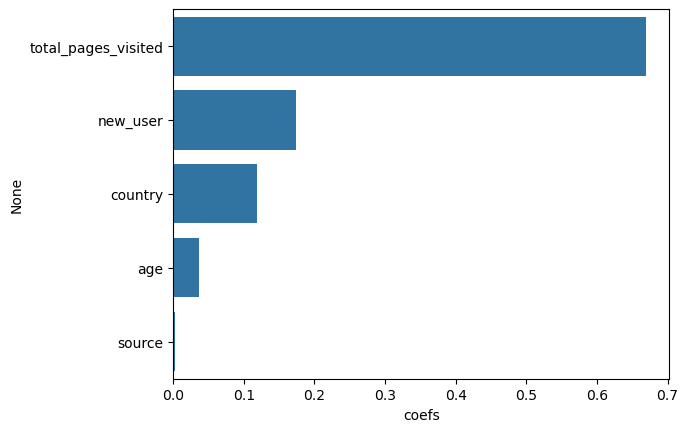

In [85]:
sns.barplot(abs(coefs), x="coefs", y=coefs.index, orient="h")

Le nombre de pages total visitées est en corrélation avec le fait que l'utilisateur est abonné ou non. C'est logique, une personne abonnée va profiter de son abonnement et consulter plus de pages.

La variable new_user est la deuxième variable ayant le plus de poids dans notre prédiction. Regardons plus en détails cette variable.

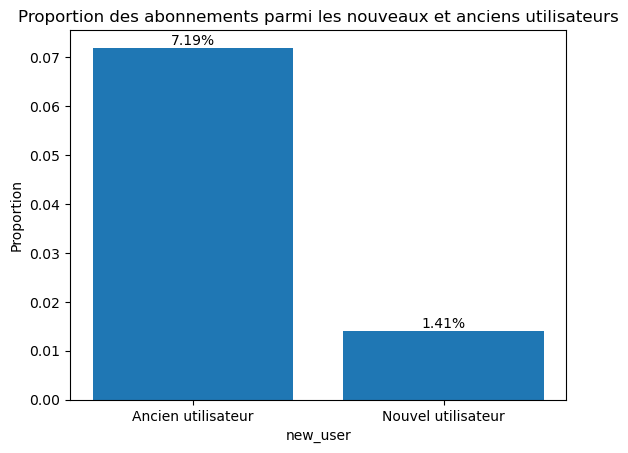

In [86]:
plt.figure()
plt.bar(data_new_user_converted_prop.index, data_new_user_converted_prop.values)
plt.title("Proportion des abonnements parmi les nouveaux et anciens utilisateurs")
plt.xlabel("new_user")
plt.ylabel("Proportion")

for i, count in enumerate(data_new_user_converted_prop):
    plt.text(i, count, str(round(100*count , 2)) + "%", ha='center', va = 'bottom')
plt.show()

Peu de nouveaux utilisateurs s'abonnent (seulement 1.41 %). En lien avec le nombre de pages vititées, je recommanderai de **proposer une période d'essai gratuite (sur une période à définir).** \
Cela permettrait aux nouveaux utilisateurs de pouvoir consulter plusieurs newsletters pendant le temps de l'essai gratuit. \
A la fin de l'essai gratuit, les utilisateurs qui souhaitent continuer d'avoir accès à toutes les newsletters devront s'abonner, sinon ils passent automatiquement à la version gratuite.

Regardons maintenant la variable country.

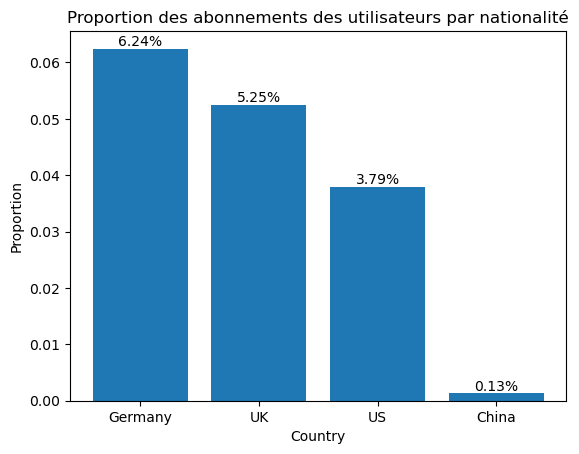

In [87]:
plt.figure()
plt.bar(data_country_converted_prop.index, data_country_converted_prop.values)
plt.title("Proportion des abonnements des utilisateurs par nationalité")
plt.xlabel("Country")
plt.ylabel("Proportion")

for i, count in enumerate(data_country_converted_prop):
    plt.text(i, count, str(round(100*count , 2)) + "%", ha='center', va = 'bottom')
plt.show()

Deux remarques peuvent être faites ici :
- il n'y a que 4 pays représentés
- seulement 0.13 % des personnes chinoises s'abonnent.

Plusieurs pistes peuvent être envisagés :
- faire de la publicité dans d'autres pays afin d'attirer de nouvelles personnes
- traduire les newsletters en mandarin

Enfin, les variables "age" et "source" ont peu d'influence sur l'abonnement, on ne s'attardera pas sur ces variables.